In [ ]:
!rm -rf TrainingData
!rm TrainingData.zip
!rm class_names.json
!rm -rf sample_data

rm: cannot remove 'TrainingData.zip': No such file or directory
rm: cannot remove 'class_names.json': No such file or directory


In [ ]:
!gdown "1vzlp1alO92vfskKdueGOz2v04M-pyr5P" || pip install gdown && gdown "1vzlp1alO92vfskKdueGOz2v04M-pyr5P"

Downloading...
From: https://drive.google.com/uc?id=1vzlp1alO92vfskKdueGOz2v04M-pyr5P
To: /content/TrainingData.zip
100% 195M/195M [00:02<00:00, 94.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vzlp1alO92vfskKdueGOz2v04M-pyr5P
To: /content/TrainingData.zip
100% 195M/195M [00:01<00:00, 136MB/s]


In [ ]:
!unzip -F /content/TrainingData.zip && echo "Unzipped!"
!rm TrainingData.zip

Archive:  /content/TrainingData.zip
   creating: TrainingData/
   creating: TrainingData/Carcharias sp. (lingual)/
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-1625-G lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-497-F lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-497-A lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-912-B lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-499-C lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-7584 lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-794-H lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-497-I lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-794-F lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-726 lingual copy.jpg  
 extracting: TrainingData/Carcharias sp. (lingual)/CMM-V-498-C ling

Resize Images:

In [ ]:
# Importing Image class from PIL module
from PIL import Image
import os
import json

training_path = "/content/TrainingData/"
dirs = [directory for directory in os.listdir(training_path)]

def process_images(dirs, im_path):
    for directory in dirs:
        for file in os.listdir(im_path + directory):
            # Opens a image in RGB mode
            im = Image.open(im_path + directory + "/" + file)
            im.thumbnail((256, 256))
            im.save(im_path + directory + "/" + file, optimize=True)

process_images(dirs, training_path)

Train a model:

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import json

In [ ]:
# Choose activation function
activation = 'sigmoid'
dataset_url = "/content/TrainingData/"

In [ ]:
batch_size = 10
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 410 files belonging to 7 classes.
Using 328 files for training.
Found 410 files belonging to 7 classes.
Using 82 files for validation.


In [ ]:
# Save class_names to json file
class_names = train_ds.class_names
print(class_names)

class_json = {}
for i in range(len(class_names)):
  class_json[i] = class_names[i]

with open("class_names.json", "w") as file:
  file.write(json.dumps(class_json, indent=4))

['Carcharhinus sp. (lingual)', 'Carcharias sp. (lingual)', 'Galeocerdo aduncus (lingual)', 'Hemipristis serra (lower lingual)', 'Hemipristis serra (upper lingual)', 'Notorynchus primigenus (lingual)', 'Otodus megalodon (lingual)']


Training Dataset:
Validation Dataset:
(10, 256, 256, 3)
(10,)


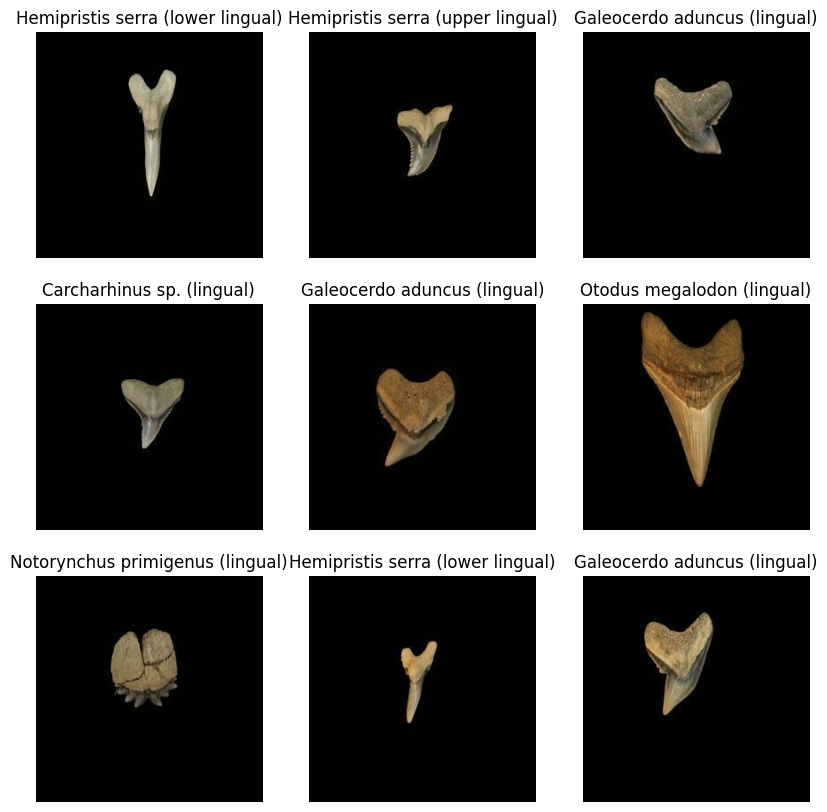

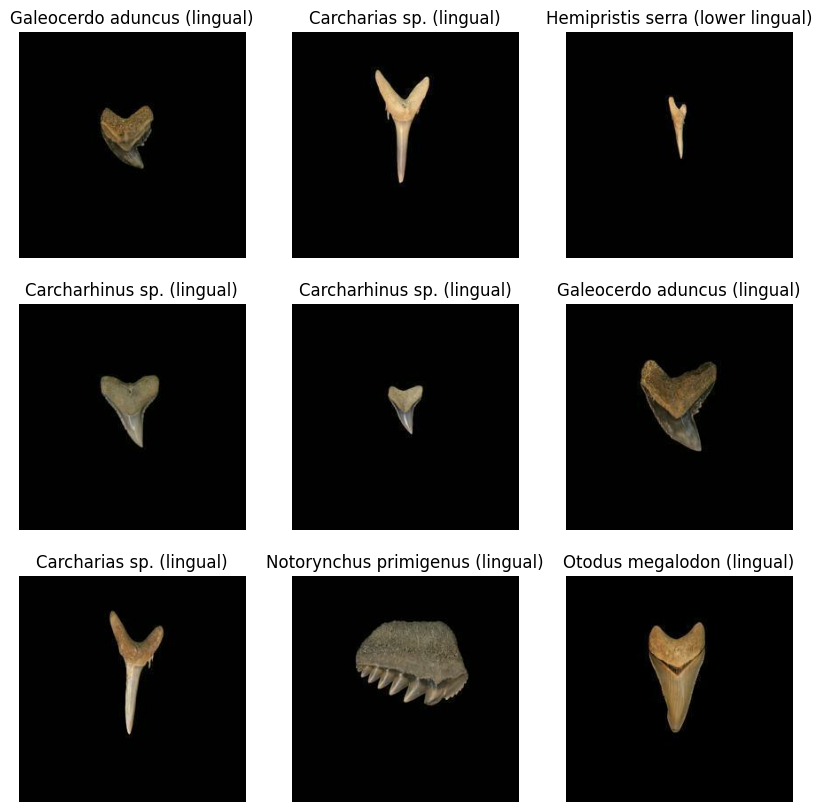

In [ ]:
# Show images in training dataset
print("Training Dataset:")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Show images in validation dataset
print("Validation Dataset:")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
# Preprocess
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len([directory for directory in os.listdir(dataset_url)])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomZoom(0.2, 0.5)
])

0.0 0.95294124


In [ ]:
# Create model
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation=activation),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation=activation),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation=activation),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5120, activation=activation),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

model.save(f'{activation}_model.h5')

Epoch 1/50
33/33 [==============================] - 111s 3s/step - loss: 10.5226 - accuracy: 0.1128 - val_loss: 3.8736 - val_accuracy: 0.0854
Epoch 2/50
33/33 [==============================] - 106s 3s/step - loss: 2.7123 - accuracy: 0.1524 - val_loss: 2.0390 - val_accuracy: 0.1585
Epoch 3/50
33/33 [==============================] - 106s 3s/step - loss: 2.2265 - accuracy: 0.1707 - val_loss: 2.2024 - val_accuracy: 0.1585
Epoch 4/50
33/33 [==============================] - 105s 3s/step - loss: 2.3102 - accuracy: 0.1341 - val_loss: 2.3057 - val_accuracy: 0.1585
Epoch 5/50
33/33 [==============================] - 102s 3s/step - loss: 2.3336 - accuracy: 0.1311 - val_loss: 2.3541 - val_accuracy: 0.1585
Epoch 6/50
33/33 [==============================] - 101s 3s/step - loss: 2.3497 - accuracy: 0.1341 - val_loss: 2.3769 - val_accuracy: 0.1585
Epoch 7/50
33/33 [==============================] - 105s 3s/step - loss: 2.3500 - accuracy: 0.1189 - val_loss: 2.3753 - val_accuracy: 0.1585
Epoch 8/50
3

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model(f'{activation}_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                 

Make a prediction:

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import json

In [ ]:
# Select activation
activation = "sigmoid"

# Input data for testing image
# TODO: Automate this step for multiple images
img_path = "/content/testImages/hastalis/1.jpg"
img_dir = "/content/testImages/hastalis/"
img_class = "hastalis"

In [ ]:
# Load model
model = tf.keras.models.load_model(f'{activation}_model.h5', compile = True)

In [ ]:
img_width, img_height = 180, 180
image = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis = 0)

prediction = model.predict(image)

predicted_class = np.argmax(prediction, axis=1)

# Load class data from data
with open("class_names.json", "r") as file:
  dirs = json.load(file)

percentages = tf.nn.softmax(prediction[0]).numpy() * 100

print(prediction)
print(["{:.20f}%".format(p) for p in percentages])
print(f"Predicted class: {dirs[str(predicted_class.tolist()[0])]}\nCorrect class: {img_class}")
if img_class == dirs[str(predicted_class.tolist()[0])]:
  print("Prediction Correct!")
else:
  print("Prediction Incorrect!")

1/1 [==============================] - 0s 295ms/step
[[4.343707  6.3268843 5.9261723 4.3218064 4.992636  4.1153917 4.888257
  5.846487 ]]
['4.34057426452636718750%', '31.53770256042480468750%', '21.12530708312988281250%', '4.24654579162597656250%', '8.30564689636230468750%', '3.45454668998718261719%', '7.48242235183715820312%', '19.50725746154785156250%']
Predicted class: Carcharias sp. (lingual)
Correct class: hastalis
Prediction Incorrect!
